### Run Incidents Model

- Here we present a demo of running inference with our model, from a checkpoint.
- To train a model for yourself, please see the `README.md` with instructions for using `run_model.py`.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import pprint
import glob
import json
from tqdm import tqdm
import cv2
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from architectures import (
    FilenameDataset,
    get_incidents_model,
    update_incidents_model_with_checkpoint,
    update_incidents_model_to_eval_mode,
    get_predictions_from_model
)
from parser_ import get_parser, get_postprocessed_args

In [9]:
# data
image_filenames = sorted(glob.glob("example_images/*"))

# model
CONFIG_FILENAME = "configs/eccv_final_model"
CHECKPOINT_PATH_FOLDER = "pretrained_weights/"

In [10]:
# you can replace the filenames with your own
image_filenames

['example_images\\earthquake.jpg',
 'example_images\\fire.jpg',
 'example_images\\flood.jpg',
 'example_images\\ship.jpg']

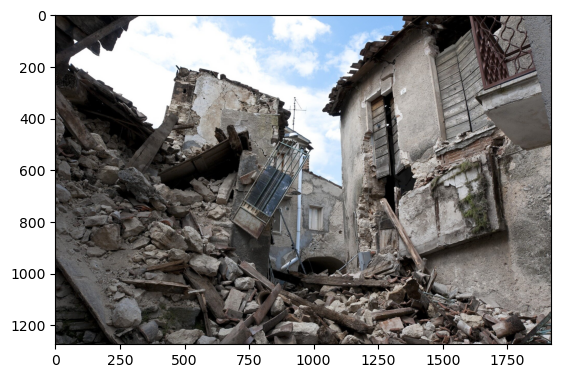

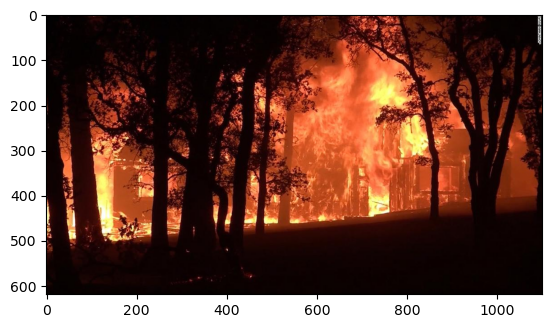

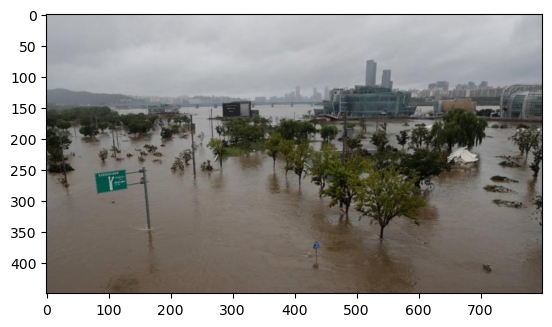

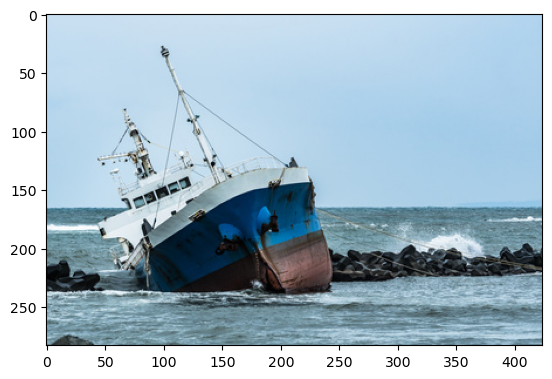

In [11]:
for image_filename in image_filenames:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    plt.imshow(img)
    plt.show()

In [12]:
# Load model from checkpoint.
parser = get_parser()
args = parser.parse_args(args="--config={} --checkpoint_path={} --mode=test --num_gpus=0".format(CONFIG_FILENAME, CHECKPOINT_PATH_FOLDER))
args = get_postprocessed_args(args)

incidents_model = get_incidents_model(args)
update_incidents_model_with_checkpoint(incidents_model, args)
update_incidents_model_to_eval_mode(incidents_model)

loading places weights for pretraining
Let's use 0 GPUs!
eccv_final_model
Loaded checkpoint 'pretrained_weights/trunk_best.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/place_best.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/incident_best.pth.tar' (epoch 15).
Switching to eval mode.


In [13]:
from utils import get_index_to_incident_mapping, get_index_to_place_mapping

In [14]:
# Set up the data loader for quickly loading images to run inference with.
print("num images: {}".format(len(image_filenames)))
targets = [image_filenames[i] for i in range(len(image_filenames))]
dataset = FilenameDataset(image_filenames, targets)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

inference_dict = {}
for idx, (batch_input, image_paths) in tqdm(enumerate(loader)):
    # run the model, get the output, set the inference_dict
    output = get_predictions_from_model(
        args,
        incidents_model,
        batch_input,
        image_paths,
        get_index_to_incident_mapping(),
        get_index_to_place_mapping(),
        inference_dict,
        topk=5
    )

0it [00:00, ?it/s]

num images: 4


4it [00:08,  2.08s/it]


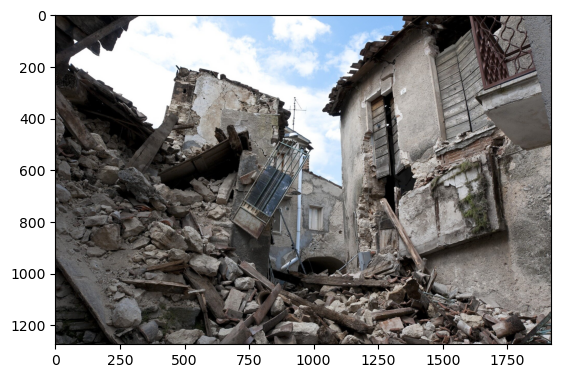

{'incident_probs': array([9.2604744e-01, 1.1029798e-02, 4.4702874e-03, 5.2067457e-04,
       1.9544814e-04], dtype=float32),
 'incidents': ['earthquake',
               'collapsed',
               'damaged',
               'rockslide rockfall',
               'burned'],
 'place_probs': array([0.26566708, 0.13693586, 0.12232041, 0.08357294, 0.07377885],
      dtype=float32),
 'places': ['building outdoor',
            'street',
            'slum',
            'house',
            'religious building']}


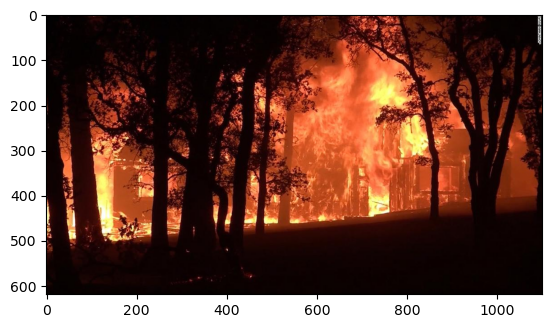

{'incident_probs': array([0.6207942 , 0.23121077, 0.06282383, 0.0406112 , 0.00209118],
      dtype=float32),
 'incidents': ['wildfire', 'on fire', 'fire whirl', 'burned', 'damaged'],
 'place_probs': array([0.8459488 , 0.07128948, 0.00922022, 0.00707669, 0.00503554],
      dtype=float32),
 'places': ['forest', 'forest road', 'mountain', 'desert', 'highway']}


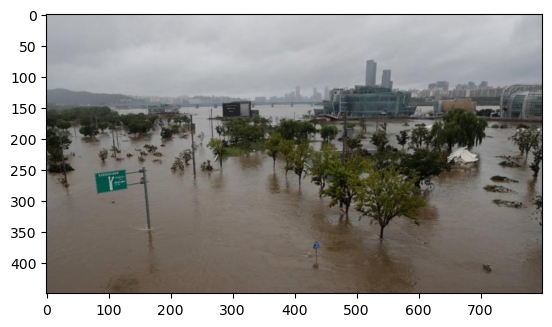

{'incident_probs': array([9.4023949e-01, 2.7635561e-02, 5.2077943e-03, 4.5292038e-03,
       3.0503439e-04], dtype=float32),
 'incidents': ['flooded',
               'tropical cyclone',
               'storm surge',
               'heavy rainfall',
               'mudslide mudflow'],
 'place_probs': array([0.3749591 , 0.15494375, 0.13527149, 0.05341305, 0.0398289 ],
      dtype=float32),
 'places': ['building outdoor', 'downtown', 'river', 'highway', 'village']}


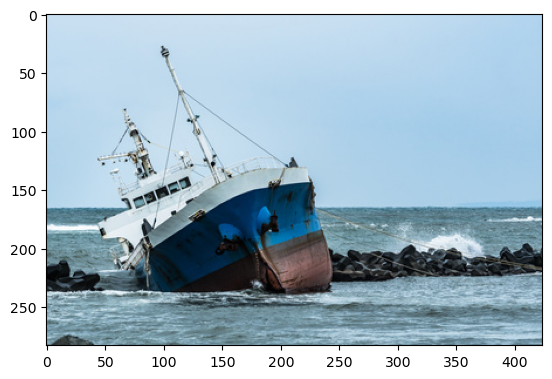

{'incident_probs': array([9.8649371e-01, 6.1292162e-06, 5.3839804e-06, 1.9247248e-06,
       1.7059651e-06], dtype=float32),
 'incidents': ['ship boat accident',
               'storm surge',
               'damaged',
               'airplane accident',
               'collapsed'],
 'place_probs': array([0.41802374, 0.1804842 , 0.07916392, 0.02241559, 0.01823319],
      dtype=float32),
 'places': ['ocean', 'beach', 'coast', 'sky', 'port']}


In [15]:
for image_filename in inference_dict:
    img = cv2.imread(image_filename)[:,:,::-1].copy() 
    plt.imshow(img)
    plt.show()
    pprint.pprint(inference_dict[image_filename])